# imports

In [1]:
#!pip install tensorflow-gpu 

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu


In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [6]:
df = pd.read_csv(
    os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [7]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [17]:
df.iloc[15]['comment_text']

'"\r\n\r\nJuelz Santanas Age\r\n\r\nIn 2002, Juelz Santana was 18 years old, then came February 18th, which makes Juelz turn 19 making songs with The Diplomats. The third neff to be signed to Cam\'s label under Roc A Fella. In 2003, he was 20 years old coming out with his own singles ""Santana\'s Town"" and ""Down"". So yes, he is born in 1983. He really is, how could he be older then Lloyd Banks? And how could he be 22 when his birthday passed? The homie neff is 23 years old. 1983 - 2006 (Juelz death, god forbid if your thinking about that) equals 23. Go to your caculator and stop changing his year of birth. My god."'

In [19]:
df[df.columns[2:]].iloc[15]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 15, dtype: int64

# Preprocess

In [ ]:
#!pip list

In [20]:
from tensorflow.keras.layers import TextVectorization

In [21]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [22]:
MAX_FEATURES = 200000 # number of words in the vocab

In [23]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [24]:
vectorizer.adapt(X.values)
#teaching vectrizer the vocabilary

In [28]:
vectorizer('my name is')

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 29, 109,   9,   0], dtype=int64)>

In [25]:
vectorized_text = vectorizer(X.values)
# x.values to convert to numpy array

In [29]:
#data pipeline
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file

In [30]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# Model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [32]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32)) #(empeding features +1 , labels)
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [33]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [35]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 3309s 473ms/step - loss: 0.0621 - val_loss: 0.0490


In [36]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

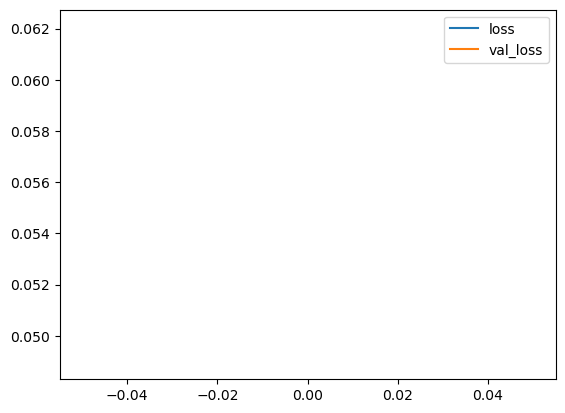

In [37]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Predictions

In [38]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [48]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 84ms/step


In [49]:
res

array([[0.99491554, 0.35386777, 0.9580697 , 0.06014106, 0.82868797,
        0.16158429]], dtype=float32)

In [50]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [53]:
df[df.columns[2:]].iloc[15]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 15, dtype: int64

In [57]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [58]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 136ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [59]:
res.shape

(1, 6)

# Model Evaluate 

In [60]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [61]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [62]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 90ms/step


In [63]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.7250859141349792, Recall:0.7759547233581543, Accuracy:0.4854563772678375


# 5. Test and Gradio

In [64]:
!pip install gradio jinja2

     ---------------------------------------- 17.3/17.3 MB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 2.1/2.1 MB 2.5 MB/s eta 0:00:00
     -------------------------------------- 319.8/319.8 kB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 75.3/75.3 kB 4.3 MB/s eta 0:00:00
     -------------------------------------- 813.6/813.6 kB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 58.3/58.3 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 84.5/84.5 kB 4.6 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 57.0/57.0 kB 1.5 MB/s eta 0:00:00
     -------------------------------------- 124.7/124.7 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 45.7/45.7 kB 1.1 MB/s eta 0:00:00
     -----------------

In [65]:
import tensorflow as tf
import gradio as gr

In [40]:
#model.save('toxicity.h5')

In [66]:
model = tf.keras.models.load_model('toxicity.h5')

In [67]:
input_str = vectorizer('hey i freaken hate you!')

In [68]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 957ms/step


In [69]:
res

array([[0.8467686 , 0.09424618, 0.5680463 , 0.05843844, 0.5153045 ,
        0.12236443]], dtype=float32)

In [70]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [71]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

C:\Users\Abin\anaconda3\lib\site-packages\gradio\inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\Abin\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\Abin\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [72]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://23b616a7372f72339e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 99ms/step
